In [1]:
from IPython.core.display import Latex
from sympy import * 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from iminuit import Minuit, cost
from scipy import stats

## Function for Latex formatting and sympy

In [2]:
def lprint(*args,**kwargs):
    """Pretty print arguments as LaTeX using IPython display system 
    
    Parameters
    ----------
    args : tuple 
        What to print (in LaTeX math mode)
    kwargs : dict 
        optional keywords to pass to `display` 
    """
    display(Latex('$$'+' '.join(args)+'$$'),**kwargs)

## Function for weighted mean

In [4]:
def weighted_mean(vals,sigs):
    values = np.array(vals)
    uncertainties = np.array(sigs)

    # Check if lengths match
    if len(values) != len(uncertainties):
        raise ValueError("Values and uncertainties must have the same length.")
    # Check for zero uncertainties to avoid division errors
    if np.any(uncertainties <= 0):
        raise ValueError("Uncertainties must be positive and non-zero.")

    # Calculate the weights
    weights = 1 / (uncertainties ** 2)
    # Calculate the weighted mean
    weighted_mean = np.sum(weights * values) / np.sum(weights)
    # Calculate the uncertainty of the weighted mean
    mean_uncertainty = np.sqrt(1 / np.sum(weights))
    
    return weighted_mean, mean_uncertainty

## Error propagation functions

In [5]:
#Error propagation for theta calculation
def error_prop_theta(Length,Height,sigL,sigH):
    # Define variables:
    L,H = symbols("L, H")
    dL,dH, dTheta = symbols("sigma_L, sigma_H, sigma_theta")
    Theta = symbols("theta")
    
    # Perimeter:
    # Define relation, and print:
    Theta = atan(H/L)
    lprint(latex(Eq(symbols('theta'),Theta)))
    
    # Calculate uncertainty and print:
    dTheta = sqrt((Theta.diff(L) * dL)**2 + (Theta.diff(H) * dH)**2)
    lprint(latex(Eq(symbols('sigma_theta'), dTheta)))
    
    # Turn expression into numerical functions 
    fTheta = lambdify((L,H),Theta)
    fdTheta = lambdify((L,dL,H,dH),dTheta)
    
    # Define values and their errors
    vL, vdL = Length,sigL
    vH, vdH = Height,sigH
    
    # Numerically evaluate expressions and print 
    vTheta = fTheta(vL,vH)
    vdTheta = fdTheta(vL,vdL,vH,vdH)
    lprint(fr'theta = ({vTheta:.4f} \pm {vdTheta:.4f})')

    return vTheta, vdTheta

#Error propagation for pendulum length calculation
def error_prop_L(mu_Ht,mu_He,mu_Hl,sig1,sig2,sig3):
    # Define variables:
    Ht,He,Hl = symbols("Ht,He,Hl")
    dHt,dHe,dHl, dL = symbols("sigma_Ht, sigma_He, sigma_Hl,sigma_L")
    
    # Define relation, and print:
    L = Ht-He-Hl/2
    lprint(latex(Eq(symbols('L'),L)))
    
    # Calculate uncertainty and print:
    dL = sqrt((L.diff(Ht) * dHt)**2 + (L.diff(He) * dHe)**2 + (L.diff(Hl) * dHl)**2)
    lprint(latex(Eq(symbols('sigma_L'), dL)))
    
    # Turn expression into numerical functions 
    fL = lambdify((Ht,He,Hl),L)
    fdL = lambdify((Ht,dHt,He,dHe,Hl,dHl),dL)
    
    # Define values and their errors
    vHt, vdHt = mu_Ht,sig1
    vHe, vdHe = mu_He,sig2
    vHl, vdHl = mu_Hl,sig3
    
    # Numerically evaluate expressions and print 
    vL = fL(vHt,vHe,vHl)
    vdL = fdL(vHt,vdHt,vHe,vdHe,vHl,vdHl)
    lprint(fr'L = ({vL:.4f} \pm {vdL:.4f})')

    return vL, vdL

def error_prop_radians(angle,sigangle):
    # Define variables:
    V,Theta = symbols("V,theta")
    dTheta,dV = symbols("sigma_theta, sigma_V")
    
    # Perimeter:
    # Define relation, and print:
    V = Theta*(pi/180)
    lprint(latex(Eq(symbols('V'),V)))
    
    # Calculate uncertainty and print:
    dV = sqrt(V.diff(Theta) * dTheta)**2
    lprint(latex(Eq(symbols('sigma_V'), dV)))
    
    # Turn expression into numerical functions 
    fV = lambdify((Theta),V)
    fdV = lambdify((Theta,dTheta),dV)
    
    # Define values and their errors
    vTheta, vdTheta = angle,sigangle
    
    # Numerically evaluate expressions and print 
    vV = fV(vTheta)
    vdV = fdV(vTheta,vdTheta)
    lprint(fr'Radians = ({vV:.4f} \pm {vdV:.4f})')

    return vV, vdV

## Function to extract midpoint values for t_pass (boi)

In [6]:
def find_midpoints(time, voltage, show_plot=True):
    """Find timing of ball crossings"""
    tops = []
    t_pass = []
    t_pass_sigma = []

    # pass sets of peaks into another list
    for i,y in enumerate(voltage):
        if y > 4.5:
            tops.append(time[i])    
    
    tops.append(50) # used to define end of last peak
    
    # masking different tops to different lists nested in an assymetrical list
    midpoint_lists = []
    past = tops[0]
    values = []

    for i in tops:
        
        if i - past < 0.03:
            values.append(i)
        
        if i - past > 0.03:
            midpoint_lists.append(values)
            values = []

        past = i

    # Assumption: peak is symmetric around top/midpoint value,
    # so mean is median is the best measure of when ball passes sensor
    for i in midpoint_lists:

        y = np.array(i)

        t_pass.append(np.mean(y))

        #using simple np.std func to determine uncertainty on mean without ddof
        # (i think ddof is set to some standard value)
        t_pass_sigma.append(np.std(y))

    return t_pass, t_pass_sigma


## Load raw data

In [7]:
boi_setup_raw = pd.read_csv('BallOnIncline_setup_raw.csv')
boi_gates_raw = pd.read_csv('BallOnIncline_gates_raw.csv')
pend_setup_raw = pd.read_csv('Pendulum_setup_raw.csv')

exp_all = pd.read_csv('boi_Exp_all.csv')
exps = list(exp_all.columns)[1:]
time = np.array(exp_all['Time'])+0.5

boi_parameters = [list(boi_setup_raw.columns)[i] for i in np.arange(0,len(list(boi_setup_raw.columns)),2)]
pend_parameters = [list(pend_setup_raw.columns)[i] for i in np.arange(0,len(list(pend_setup_raw.columns)),2)]
gates = list(boi_gates_raw.columns)[0:-1]
print(boi_parameters)
print(gates)

['L', 'H', 'Theta1', 'Theta2', 'drail', 'dball']
['Gate1', 'Gate2', 'Gate3', 'Gate4']


## Prepare boi data

In [8]:
#Weighted means and uncertainties of key parameters for boi
boi_weighted_means = {}

for param in boi_parameters:
    vals = boi_setup_raw[param]
    vals = vals[vals>0]
    sigs = boi_setup_raw[f'{param}_sig']
    sigs = sigs[sigs>0]
    mean,sig = weighted_mean(vals,sigs)

    #Check for consistency
    ind_max = 0
    ind_min = 0
    max_el = vals[0]
    min_el = vals[0]
    for i,v in enumerate(vals):
        if v>max_el:
            max_el = v
            ind_max = i
        if v<min_el:
            min_el = v
            ind_min = i
            
    max_val,max_sig = [max_el,sigs[ind_max]]
    min_val,min_sig = [min_el,sigs[ind_min]]

    if max_val-max_sig*2 < min_val+min_sig*2:
        sig = sig
    else: 
        sig = np.std(vals)
        print(f'Measurements inconsistent for {param}. Using standard deviation of measurements as error on the mean')
    boi_weighted_means[param] = [mean,sig]

weighted_means_df = pd.DataFrame.from_dict(boi_weighted_means)

#Calculate theta from L and H, calculate theta in radians and caluclate mean theta
vTheta, vdTheta = error_prop_theta(weighted_means_df['L'][0],weighted_means_df['H'][0],
                                   weighted_means_df['L'][1],weighted_means_df['H'][1])
weighted_means_df['Theta3'] = [vTheta,vdTheta]

for theta in ['Theta1','Theta2']:
    radian, radian_sig = error_prop_radians(weighted_means_df[theta][0],weighted_means_df[theta][1])
    weighted_means_df.loc[0,theta] = radian
    weighted_means_df.loc[1,theta] = radian_sig

#Calculate mean gate distances
for gate in gates:
    vals = boi_gates_raw[gate]
    sigs = boi_gates_raw['Sig']
    mean,sig = weighted_mean(vals,sigs)

    #Check for consistency
    ind_max = 0
    ind_min = 0
    max_el = vals[0]
    min_el = vals[0]
    for i,v in enumerate(vals):
        if v>max_el:
            max_el = v
            ind_max = i
        if v<min_el:
            min_el = v
            ind_min = i
            
    max_val,max_sig = [max_el,sigs[ind_max]]
    min_val,min_sig = [min_el,sigs[ind_min]]

    if max_val-max_sig*2 < min_val+min_sig*2:
        sig = sig
    else: 
        sig = np.std(vals)
        print(f'Measurements inconsistent for {gate}. Using standard deviation of measurements as error on the mean')
    weighted_means_df[gate] = [mean,sig]

weighted_means_df.to_csv('boi_weighted_means.csv',index=True)

Measurements inconsistent for L. Using standard deviation of measurements as error on the mean
Measurements inconsistent for H. Using standard deviation of measurements as error on the mean
Measurements inconsistent for dball. Using standard deviation of measurements as error on the mean


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Measurements inconsistent for Gate1. Using standard deviation of measurements as error on the mean
Measurements inconsistent for Gate2. Using standard deviation of measurements as error on the mean
Measurements inconsistent for Gate3. Using standard deviation of measurements as error on the mean
Measurements inconsistent for Gate4. Using standard deviation of measurements as error on the mean


In [9]:
#Calculate gate timings from experiment direction 1 and 2.
exp_ts = {}
exp_ts_sig = {}
for exp in exps:
    voltage = np.array(exp_all[exp])
    t_pass,t_pass_sig = find_midpoints(time, voltage)
    t_pass = t_pass[:]-t_pass[0]
    exp_ts[exp] = t_pass
    exp_ts_sig[exp] = t_pass_sig

exp_ts_df = pd.DataFrame.from_dict(exp_ts)
exp_ts_sig_df = pd.DataFrame.from_dict(exp_ts_sig)

exp1_gate_ts = []
exp2_gate_ts = []

for T in range(0,5):
    vals = np.array(exp_ts_df.iloc[T])[0:5]
    sigs = exp_ts_sig_df.iloc[T][0:5]
    mean,sig = weighted_mean(vals,sigs)
    exp1_gate_ts.append([mean,sig])

    vals = np.array(exp_ts_df.iloc[T])[5:10]
    sigs = exp_ts_sig_df.iloc[T][5:10]
    mean,sig = weighted_mean(vals,sigs)
    exp2_gate_ts.append([mean,sig])

print(np.shape(exp1_gate_ts))

(5, 2)


EXP1
Fit value: a = 1.62313 +/- 0.12944
Fit value: v0 = 0.68640 +/- 0.02729
Chi2 value: 0.01   Ndof = 2    Prob(Chi2,Ndof) = 0.996
EXP2
Fit value: a = 1.64515 +/- 0.13093
Fit value: v0 = 0.68956 +/- 0.02744
Chi2 value: 0.01   Ndof = 2    Prob(Chi2,Ndof) = 0.994
           L          H    Theta1    Theta2     drail     dball    Theta3  \
0  88.954000  23.446857  0.255308  0.262941  0.610000  1.209038  0.257722   
1   0.491178   0.143254  0.003631  0.003631  0.022875  0.115407  0.002030   

       Gate1      Gate2      Gate3      Gate4    EXP1_a    EXP2_a  
0  15.045857  30.057857  45.124286  60.390000  4.745083  4.799635  
1   0.419223   0.433494   0.722132   0.708819  0.036800  0.037221  


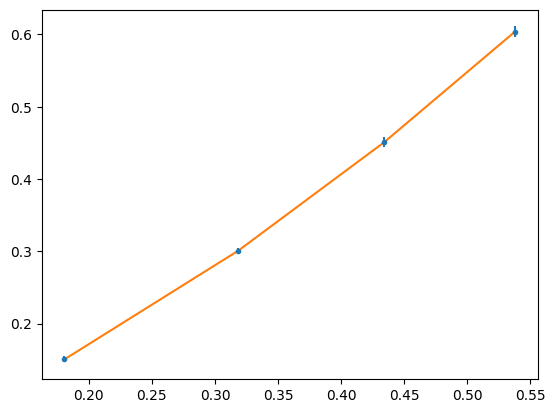

In [18]:
data_distance = np.array(pd.read_csv('boi_weighted_means.csv',usecols=[8,9,10,11]).iloc[0]/100)
erdata_distance = np.array(pd.read_csv('boi_weighted_means.csv',usecols=[8,9,10,11]).iloc[1]/100)
data_times = np.array(exp1_gate_ts)[1:,0]

def f_dist(t, a, v0):
    return v0*t + a*(0.5)*(t**2)
#number degrees of freedom. data points - free parameters
Ndof = 4-2

#EXP1
a_fit = cost.LeastSquares(data_times, data_distance, erdata_distance, f_dist)
mfit = Minuit(a_fit, a = 6, v0 = 0)
mfit.migrad()

fit_a_exp1 = [mfit.values[0],mfit.errors[0]]
print('EXP1')
for name in mfit.parameters :
    value, error = mfit.values[name], mfit.errors[name]
    print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")
chi2 = mfit.fval
p_value = stats.chi2.sf(chi2, Ndof)
print(f"Chi2 value: {chi2:.2f}   Ndof = {Ndof:.0f}    Prob(Chi2,Ndof) = {p_value:5.3f}")

plt.errorbar(data_times, data_distance,yerr=erdata_distance,fmt='.')
plt.plot(data_times, f_dist(data_times,mfit.values[0], mfit.values[1]))

#EXP2
data_times = np.array(exp2_gate_ts)[1:,0]
a_fit = cost.LeastSquares(data_times, data_distance, erdata_distance, f_dist)
mfit = Minuit(a_fit, a = 6, v0=0)
mfit.migrad()

fit_a_exp2 = [mfit.values[0],mfit.errors[0]]
print('EXP2')
for name in mfit.parameters :
    value, error = mfit.values[name], mfit.errors[name]
    print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")
chi2 = mfit.fval
p_value = stats.chi2.sf(chi2, Ndof)
print(f"Chi2 value: {chi2:.2f}   Ndof = {Ndof:.0f}    Prob(Chi2,Ndof) = {p_value:5.3f}")

df = pd.read_csv('boi_weighted_means.csv',index_col=0)
print(df)
df['EXP1_a'] = fit_a_exp1
df['EXP2_a'] = fit_a_exp2
df.to_csv('boi_weighted_means.csv')

## Prepare pend data

In [19]:
pend_weighted_means = {}

for param in pend_parameters[2:]:
    vals = pend_setup_raw[param]
    vals = vals[vals>0]
    sigs = pend_setup_raw[f'{param}_sig']
    sigs = sigs[sigs>0]
    mean,sig = weighted_mean(vals,sigs)

    #Check for consistency
    ind_max = 0
    ind_min = 0
    max_el = vals[0]
    min_el = vals[0]
    for i,v in enumerate(vals):
        if v>max_el:
            max_el = v
            ind_max = i
        if v<min_el:
            min_el = v
            ind_min = i
            
    max_val,max_sig = [max_el,sigs[ind_max]]
    min_val,min_sig = [min_el,sigs[ind_min]]

    if max_val-max_sig*2 < min_val+min_sig*2:
        sig = sig
    else: 
        sig = np.std(vals)
        print(f'Measurements inconsistent for {param}. Using standard deviation of measurements as error on the mean')
    pend_weighted_means[param] = [mean,sig]

Ht,Ht_sig = weighted_mean(np.append(np.array(pend_setup_raw['L_laser']), np.array(pend_setup_raw['L_tape'])),
                        np.append(np.array(pend_setup_raw['L_laser_sig']),np.array(pend_setup_raw['L_tape_sig'])))
pend_weighted_means['Ht'] = [Ht,Ht_sig]
weighted_means_df = pd.DataFrame.from_dict(pend_weighted_means)

vL, vdL = error_prop_L(weighted_means_df.loc[0,'Ht'],weighted_means_df.loc[0,'L_wg'],weighted_means_df.loc[0,'L_weight'],
                       weighted_means_df.loc[1,'Ht'],weighted_means_df.loc[1,'L_wg'],weighted_means_df.loc[1,'L_weight'])

weighted_means_df['L'] = [vL,vdL]
print(weighted_means_df)
weighted_means_df.to_csv('pend_weighted_means.csv')

Measurements inconsistent for L_weight. Using standard deviation of measurements as error on the mean
Measurements inconsistent for L_wg. Using standard deviation of measurements as error on the mean


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

    L_weight       L_wg           Ht            L
0  10.046962  15.144430  2220.495426  2200.327515
1   0.108944   0.092694     0.035158     0.113117


In [20]:
use_exps = np.array([1,2,4])
pend_t_raw = pd.read_csv('Pendul_T_raw.csv',usecols=use_exps)
exps = list(pend_t_raw.columns)
for exp in exps:
    pend_t_raw[exp] = pend_t_raw[exp]-pend_t_raw.loc[0,exp]

pend_t_sigs = np.array(pd.read_csv('pend_t_uncert.csv',usecols=use_exps-1).iloc[0])
pend_t_means = []
for i in range(0,7):
    vals = pend_t_raw.iloc[i]
    mean,sig = weighted_mean(vals,pend_t_sigs)
    pend_t_means.append([mean,sig])

pend_t_means = np.array(pend_t_means)

pend_Ns = range(len(pend_t_means[:,0]))

def linear_pdf(x, a, c) :
    """linear fit"""
    return a*x + c

cfit = cost.LeastSquares(pend_Ns,pend_t_means[:,0], pend_t_means[:,1], linear_pdf)
mfit = Minuit(cfit, a = 10, c = -3)
mfit.migrad() 

for name in mfit.parameters:
    print("Fit value (exp): {0} = {1:.5f} +/- {2:.5f}".format(name, mfit.values[name], mfit.errors[name]))
chi2 = mfit.fmin.fval
Ndof = len(pend_Ns) - len(mfit.values[:])
Prob = stats.chi2.sf(chi2, Ndof)
print(f"  Model fit:  Prob(Chi2={chi2:6.1f}, Ndof={Ndof:3d}) = {Prob:7.5f}")

df = pd.read_csv('pend_weighted_means.csv',index_col=0)
df['T'] = [mfit.values['a'],mfit.errors['a']]
df.to_csv('pend_weighted_means.csv')

Fit value (exp): a = 9.37279 +/- 0.00724
Fit value (exp): c = -0.06216 +/- 0.02610
  Model fit:  Prob(Chi2=  10.1, Ndof=  5) = 0.07235


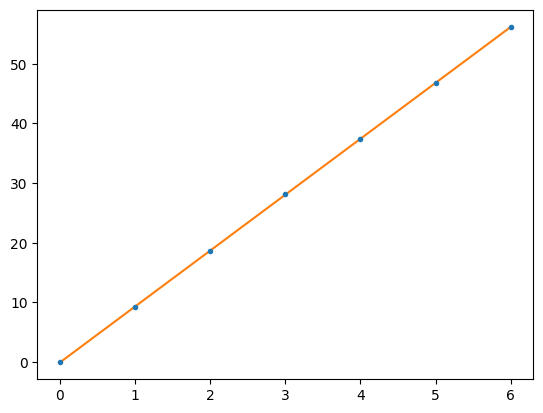

In [21]:
linear_vector = np.vectorize(linear_pdf)

plt.errorbar(pend_Ns,pend_t_means[:,0],yerr=pend_t_means[:,1],fmt='.')
plt.plot(pend_Ns,np.array(pend_Ns)*mfit.values['a']+mfit.values['c'])

## Calculate g from both experiments

In [25]:
#Error propagation for pendulum length calculation
def error_prop_pend(mu_T,mu_L,sigT,sigL):
    # Define variables:
    T,L,g = symbols("T,L,g")
    dT,dL,dg = symbols("sigma_T, sigma_L, sigma_g")
    
    # Define relation, and print:
    g = L * ((2*pi)/T)**2
    lprint(latex(Eq(symbols('g'),g)))
    
    # Calculate uncertainty and print:
    dg = sqrt((g.diff(T) * dT)**2 + (g.diff(L) * dL)**2)
    dg1 = (g.diff(T) * dT)**2
    dg2 = (g.diff(L) * dL)**2
    lprint(latex(Eq(symbols('sigma_g'), dg)))
    lprint(latex(Eq(symbols('sigma_g1'), dg1)))
    lprint(latex(Eq(symbols('sigma_g2'), dg2)))
    
    # Turn expression into numerical functions 
    fg = lambdify((T,L),g)
    fdg = lambdify((T,dT,L,dL),dg)
    fdg1 = lambdify((T,dT,L,dL),dg1)
    fdg2 = lambdify((T,dT,L,dL),dg2)

    # Define values and their errors
    vT, vdT = mu_T,sigT
    vL, vdL = mu_L,sigL
    
    # Numerically evaluate expressions and print 
    vg = fg(vT,vL)
    vdg = fdg(vT,vdT,vL,vdL)
    vdg1 = fdg1(vT,vdT,vL,vdL)
    vdg2 = fdg2(vT,vdT,vL,vdL)
    lprint(fr'sigg1 = ({vdg1:.4f})')
    lprint(fr'sigg2 = ({vdg2:.4f})')
    lprint(fr'g = ({vg:.4f} \pm {vdg:.4f})')


    return vg, vdg

#Error propagation for pendulum length calculation
def error_prop_boi(mu_a,mu_D,mu_r,mu_theta,siga,sigD,sigr,sig_theta):
    # Define variables:
    a,D,r,Theta,g = symbols("a,D,r,theta,g")
    da,dD,dr,dTheta,dg = symbols("sigma_a, sigma_D,sigma_r,sigma_theta,sigma_g")
    dg1,dg2,dg3,dg4 = symbols("sigma_g1,sigma_g2,sigma_g3,sigma_g4")
    
    # Define relation, and print:
    g = (a/sin(Theta))*(1 + (2/5)*(D**2)/(D**2 - r**2))
    lprint(latex(Eq(symbols('g'),g)))
    
    # Calculate uncertainty and print:
    dg = sqrt((g.diff(a) * da)**2 + (g.diff(Theta) * dTheta)**2 + (g.diff(D) * dD)**2 + (g.diff(r) * dr)**2)
    lprint(latex(Eq(symbols('sigma_g'), dg)))

    dg1 = (g.diff(a) * da)**2
    dg2 = (g.diff(Theta) * dTheta)**2
    dg3 = (g.diff(D) * dD)**2
    dg4 = (g.diff(r) * dr)**2
    lprint(latex(Eq(symbols('sigma_g1'), dg1)))
    lprint(latex(Eq(symbols('sigma_g2'), dg2)))
    lprint(latex(Eq(symbols('sigma_g3'), dg3)))
    lprint(latex(Eq(symbols('sigma_g4'), dg4)))
    
    # Turn expression into numerical functions 
    fg = lambdify((a,D,r,Theta),g)
    fdg = lambdify((a,da,D,dD,r,dr,Theta,dTheta),dg)

    fdg1 = lambdify((a,da,D,dD,r,dr,Theta,dTheta),dg1)
    fdg2 = lambdify((a,da,D,dD,r,dr,Theta,dTheta),dg2)
    fdg3 = lambdify((a,da,D,dD,r,dr,Theta,dTheta),dg3)
    fdg4 = lambdify((a,da,D,dD,r,dr,Theta,dTheta),dg4)
    
    # Define values and their errors
    va, vda = mu_a,siga
    vD, vdD = mu_D,sigD
    vr, vdr = mu_r,sigr
    vTheta, vdTheta = mu_theta,sig_theta
    
    # Numerically evaluate expressions and print 
    vg = fg(va,vD,vr,vTheta)
    vdg = fdg(va,vda,vD,vdD,vr,vdr,vTheta,vdTheta)
    lprint(fr'g = ({vg:.4f} \pm {vdg:.4f})')

    vdg1 = fdg1(va,vda,vD,vdD,vr,vdr,vTheta,vdTheta)
    vdg2 = fdg2(va,vda,vD,vdD,vr,vdr,vTheta,vdTheta)
    vdg3 = fdg3(va,vda,vD,vdD,vr,vdr,vTheta,vdTheta)
    vdg4 = fdg4(va,vda,vD,vdD,vr,vdr,vTheta,vdTheta)
    lprint(fr'sig_g1 = ({vdg1:.4f})')
    lprint(fr'sig_g2 = ({vdg2:.4f})')
    lprint(fr'sig_g3 = ({vdg3:.4f})')
    lprint(fr'sig_g4 = ({vdg4:.4f})')

    return vg, vdg

In [27]:
df = pd.read_csv('pend_weighted_means.csv')
mu_L, sigL = df['L']/100
mu_T, sigT = df['T']
print('Pendulum length and uncertainty:', mu_L, sigL)
print('Pendulum period and uncertainty:', mu_T, sigT)
error_prop_pend(mu_T,mu_L,sigT,sigL)

df = pd.read_csv('boi_weighted_means.csv')

mu_a,siga = df['EXP1_a']
mu_D,sigD = df['dball']/100
mu_r,sig_r = df['drail']/100
mu_theta,sig_theta = df['Theta1']
print('Boi1 acceleration and uncertainty:', mu_a, siga)
print('Boi1 ball diameter and uncertainty:', mu_D, sigD)
print('Boi1 rail diameter and uncertainty:', mu_r, sig_r)
print('Boi1 angle and uncertainty:', mu_theta, sig_theta)

error_prop_boi(mu_a,mu_D,mu_r,mu_theta,siga,sigD,sig_r,sig_theta)

mu_a,siga = df['EXP2_a']
mu_D,sigD = df['dball']/100
mu_r,sig_r = df['drail']/100
mu_theta,sig_theta = df['Theta2']
print('Boi2 acceleration and uncertainty:', mu_a, siga)
print('Boi2 ball diameter and uncertainty:', mu_D, sigD)
print('Boi2 rail diameter and uncertainty:', mu_r, sig_r)
print('Boi2 angle and uncertainty:', mu_theta, sig_theta)

error_prop_boi(mu_a,mu_D,mu_r,mu_theta,siga,sigD,sig_r,sig_theta)



Pendulum length and uncertainty: 22.003275150600057 0.001131170585859604
Pendulum period and uncertainty: 9.372788979737734 0.0072376564897228


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Boi1 acceleration and uncertainty: 1.6231347876517677 0.129444933915794
Boi1 ball diameter and uncertainty: 0.012090384615384616 0.001154068888758379
Boi1 rail diameter and uncertainty: 0.006099999999999999 0.000228747855498907
Boi1 angle and uncertainty: 0.2553081055426936 0.0036305042945958


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Boi2 acceleration and uncertainty: 1.6451462211368044 0.130934691187693
Boi2 ball diameter and uncertainty: 0.012090384615384616 0.001154068888758379
Boi2 rail diameter and uncertainty: 0.006099999999999999 0.000228747855498907
Boi2 angle and uncertainty: 0.2629405646177611 0.0036305042945958


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

(np.float64(9.725708001016294), np.float64(0.8203379111304718))

In [24]:
dtheta1 = df.loc[0,'Theta1']-df.loc[0,'Theta2']
print(dtheta1)
dtheta2 = ((df.loc[0,'Theta1']-df.loc[0,'Theta2'])*np.sin(df.loc[0,'Theta3']))/((df.loc[0,'Theta1']+df.loc[0,'Theta2'])*np.cos(df.loc[0,'Theta3']))
print(dtheta2)

-0.007632459075067488
-0.0038819098322470623


In [ ]:
#Calculating percentage weight of each error contribution

#Pendulum
#pendulum length